In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch as th
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from torch.distributions import constraints
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv("/home/gabriel/Documents/PBML/diabetes.csv")

X = df.drop("Outcome", axis=1)  # split between variables and target
y = df.loc[:, 'Outcome']

over_sampler = RandomOverSampler(random_state=1234)  # balancing the data with over sampling
X, y = over_sampler.fit_resample(X, y)

# Apply Min-Max scaling to X
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

X = X.to_numpy()  # convert to numpy array
y = y.to_numpy()

X = th.tensor(X, dtype=th.float32)
y = th.tensor(y, dtype=th.float32)

# Define the Bayesian logistic regression model. Priors have been chosen from a previously run MCMC model
def model(X, y):
    b = pyro.sample('b', dist.Normal(-5.47, 0.53))
    w1 = pyro.sample('w1', dist.Normal(0.12, 0.03))
    w2 = pyro.sample('w2', dist.Normal(0.03, 0.01))
    w3 = pyro.sample('w3', dist.Normal(-0.02, 0.01))
    w4 = pyro.sample('w4', dist.Normal(0.00, 0.01))
    w5 = pyro.sample('w5', dist.Normal(0.00, 0.01))
    w6 = pyro.sample('w6', dist.Normal(0.06, 0.01))
    w7 = pyro.sample('w7', dist.Normal(0.67, 0.24))
    w8 = pyro.sample('w8', dist.Normal(0.02, 0.01))

    logits = b + w1 * X[:, 0] + w2 * X[:, 1] + w3 * X[:, 2] + w4 * X[:, 3] + w5 * X[:, 4] + w6 * X[:, 5] + w7 * X[:, 6] + w8 * X[:, 7]
    with pyro.plate('data', X.shape[0]):
        pyro.sample('obs', dist.Bernoulli(logits=logits), obs=y)
    return logits



def guide(X, y):
    b_loc = pyro.param('b_loc', th.tensor(-5.47))
    b_scale = pyro.param('b_scale', th.tensor(0.05), constraint=dist.constraints.positive)
    b = pyro.sample('b', dist.Normal(b_loc, b_scale))

    w1_loc = pyro.param('w1_loc', th.tensor(0.12))
    w1_scale = pyro.param('w1_scale', th.tensor(0.03), constraint=dist.constraints.positive)
    w1 = pyro.sample('w1', dist.Normal(b_loc, b_scale))

    w2_loc = pyro.param('w2_loc', th.tensor(0.03))
    w2_scale = pyro.param('w2_scale', th.tensor(0.01), constraint=dist.constraints.positive)
    w2 = pyro.sample('w2', dist.Normal(w2_loc, w2_scale))

    w3_loc = pyro.param('w3_loc', th.tensor(-0.02))
    w3_scale = pyro.param('w3_scale', th.tensor(0.01), constraint=dist.constraints.positive)
    w3 = pyro.sample('w3', dist.Normal(w3_loc, w3_scale))

    w4_loc = pyro.param('w4_loc', th.tensor(0.00))
    w4_scale = pyro.param('w4_scale', th.tensor(0.01), constraint=dist.constraints.positive)
    w4 = pyro.sample('w4', dist.Normal(w4_loc, w4_scale))

    w5_loc = pyro.param('w5_loc', th.tensor(0.00))
    w5_scale = pyro.param('w5_scale', th.tensor(0.01), constraint=dist.constraints.positive)
    w5 = pyro.sample('w5', dist.Normal(w5_loc, w5_scale))

    w6_loc = pyro.param('w6_loc', th.tensor(0.06))
    w6_scale = pyro.param('w6_scale', th.tensor(0.01), constraint=dist.constraints.positive)
    w6 = pyro.sample('w6', dist.Normal(w6_loc, w6_scale))

    w7_loc = pyro.param('w7_loc', th.tensor(0.67))
    w7_scale = pyro.param('w7_scale', th.tensor(0.24), constraint=dist.constraints.positive)
    w7 = pyro.sample('w7', dist.Normal(w7_loc, w7_scale))

    w8_loc = pyro.param('w8_loc', th.tensor(0.02))
    w8_scale = pyro.param('w8_scale', th.tensor(0.01), constraint=dist.constraints.positive)
    w8 = pyro.sample('w8', dist.Normal(w8_loc, w8_scale))

    return th.sigmoid(b + w1 * X[:, 0] + w2 * X[:, 1] + w3 * X[:, 2] + w4 * X[:, 3] + w5 * X[:, 4] + w6 * X[:, 5] + w7 * X[:, 6] + w8 * X[:, 7])


optimizer = pyro.optim.Adam({"lr": 0.001})

elbo = pyro.infer.Trace_ELBO(num_particles=64,
                             vectorize_particles=True)


# Initialize the SVI object with the model, guide, optimizer, and loss function
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

loss = []
num_iters = 7000

num_folds = 5  # number of cross-validation folds
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
sensitivities = []
specificities = []

for train_indices, test_indices in skf.split(X, y):
    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]

    # Clear the parameter store for each fold
    pyro.clear_param_store()

    elbo_values_fold = []  # List to store ELBO values for the current fold
    
    for i in range(num_iters):
        elbo = svi.step(X_train, y_train)  # Calculate ELBO for each step
        


    predicted_probs = guide(X_test, None)  # compute predictions over test set
    predicted_labels = (predicted_probs > 0.495).float()  # predictions with probabilities over 0.5 are positive
    cm = confusion_matrix(y_test, predicted_labels)  # create confusion matrix
    # Extract true positive, true negative, false positive, and false negative from confusion matrix
    tn, fp, fn, tp = cm.ravel()

    # Calculate sensitivity and specificity
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    sensitivities.append(sensitivity)
    specificities.append(specificity)

# Calculate mean and standard deviation of sensitivity and specificity
mean_sensitivity = np.mean(sensitivities)
std_sensitivity = np.std(sensitivities)
mean_specificity = np.mean(specificities)
std_specificity = np.std(specificities)

# Print mean and standard deviation of sensitivity and specificity
print("Mean Sensitivity:", mean_sensitivity)
print("Standard Deviation Sensitivity:", std_sensitivity)
print("Mean Specificity:", mean_specificity)
print("Standard Deviation Specificity:", std_specificity)





Mean Sensitivity: 0.74
Standard Deviation Sensitivity: 0.2345207879911715
Mean Specificity: 0.378
Standard Deviation Specificity: 0.2646053665366596


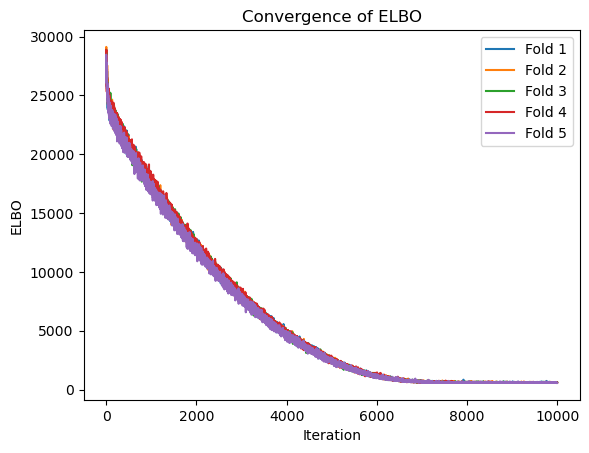

In [9]:
# Plot the ELBO values for each fold
for i, elbo_values_fold in enumerate(elbo_values):
    plt.plot(elbo_values_fold, label=f"Fold {i+1}")

plt.xlabel("Iteration")
plt.ylabel("ELBO")
plt.title("Convergence of ELBO")
plt.legend()
plt.show()

In [3]:
print(sensitivities) 

[0.86, 0.9, 0.85, 0.55, 0.84]


Iteration     0 - Loss: 581.9690
Iteration   100 - Loss: 587.6829
Iteration   200 - Loss: 602.3411
Iteration   300 - Loss: 580.7588
Iteration   400 - Loss: 579.3448
Iteration   500 - Loss: 582.8054
Iteration   600 - Loss: 586.9952
Iteration   700 - Loss: 582.7182
Iteration   800 - Loss: 589.0619
Iteration   900 - Loss: 583.3051
Iteration  1000 - Loss: 586.5014
Iteration  1100 - Loss: 580.5601
Iteration  1200 - Loss: 588.8039
Iteration  1300 - Loss: 577.2720
Iteration  1400 - Loss: 582.0925
Iteration  1500 - Loss: 593.1580
Iteration  1600 - Loss: 578.8940
Iteration  1700 - Loss: 591.0967
Iteration  1800 - Loss: 587.3831
Iteration  1900 - Loss: 578.0929
Iteration  2000 - Loss: 587.2207
Iteration  2100 - Loss: 604.4011
Iteration  2200 - Loss: 581.6959
Iteration  2300 - Loss: 582.5171
Iteration  2400 - Loss: 581.4879
Iteration  2500 - Loss: 575.1416
Iteration  2600 - Loss: 575.3026
Iteration  2700 - Loss: 580.4837
Iteration  2800 - Loss: 583.1576
Iteration  2900 - Loss: 577.9217
Iteration 

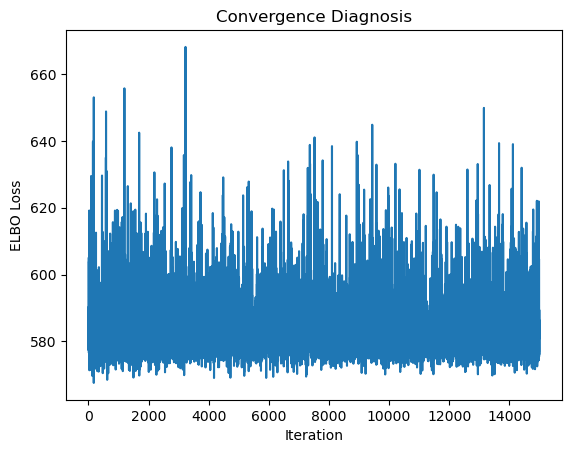

In [4]:
num_iters = 15000  # number of iterations for training
losses = []  # initialize the list to store losses

for i in range(num_iters):
    loss = svi.step(X_train, y_train)
    losses.append(loss)
    if i % 100 == 0:
        print("Iteration {:>5d} - Loss: {:.4f}".format(i, loss))

# Plot the ELBO loss over iterations
plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("ELBO Loss")
plt.title("Convergence Diagnosis")
plt.show()